In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [64]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [65]:
len(words)


32033

In [66]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [87]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [68]:
# # MLP revisited
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C  = torch.randn((vocab_size, n_embd),            generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# #b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# b2 = torch.randn(vocab_size,                      generator=g) * 0

# # BatchNorm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, W2, b2, bngain, bnbias]
# print(sum(p.nelement() for p in parameters)) # number of parameters in total
# for p in parameters:
#   p.requires_grad = True

In [88]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch. randn(n_hidden, generator=g) * 0.01
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01
b2 = torch. randn(vocab_size,generator=g) * 0

bngain = torch.ones ( (1, n_hidden))
bnbias = torch.zeros ((1, n_hidden))

bmean_running = torch.zeros ( (1, n_hidden))
bnstd_running = torch.ones ((1, n_hidden))

parameters = [C, W1, b1, W2, b2,bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
# print(parameters)
for p in parameters:
    p. requires_grad = True

12297


In [70]:
(torch. randn (10000) * 0.2).std()

tensor(0.2028)

In [71]:
(5/3) / 30 ** 0.5

0.3042903097250923

tensor(-0.0053) tensor(1.0048)
tensor(-0.0015) tensor(3.1740)


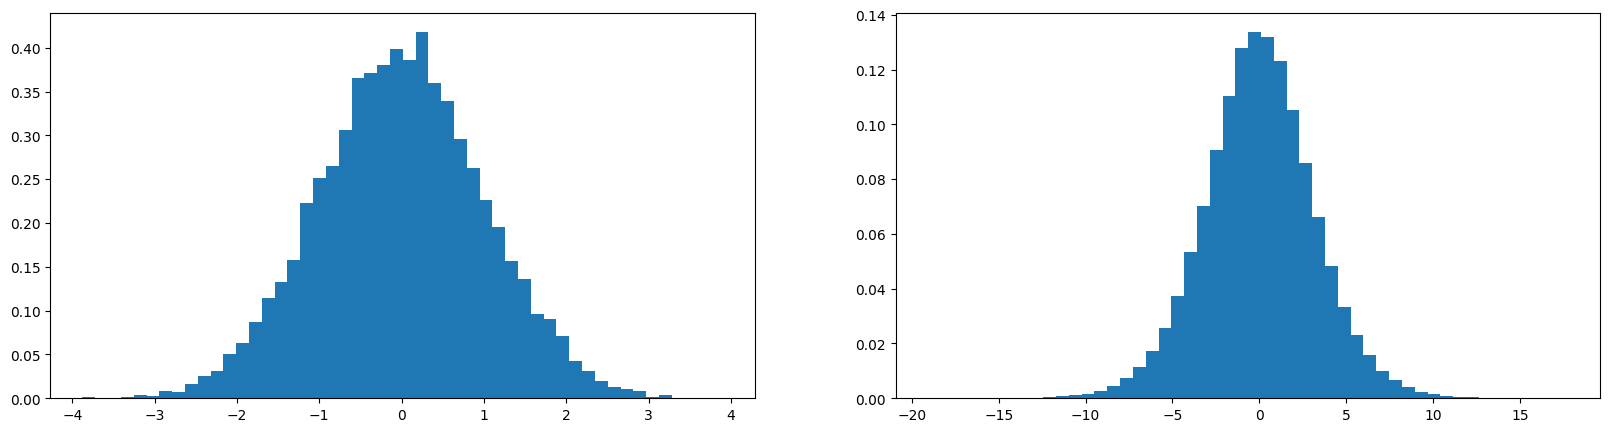

In [89]:
x = torch. randn (1000, 10)
w = torch. randn(10, 200)
y =x @ w
print (x.mean (), x.std())
print(y.mean(), y.std())
plt. figure(figsize=(20, 5))
plt.subplot (121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt. subplot (122)
plt.hist(y.view(-1). tolist(), 50, density=True);

In [85]:
hpreact.shape

torch.Size([32, 200])

In [86]:
hpreact.mean (0, keepdim=True) .shape

torch.Size([1, 200])

In [90]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # emb = C[Xb] # embed the characters into vectors
  # embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # # Linear layer
  # hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  bmeani = hpreact.mean (0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bmeani) / bnstdi + bbias

  with torch.no_grad():
    bmean_running = 0.999 * bmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
  h = torch. tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi. append (loss. log10().item())
  # break


      0/ 200000: 3.3014
  10000/ 200000: 2.4789
  20000/ 200000: 2.3364
  30000/ 200000: 2.1072
  40000/ 200000: 2.0523
  50000/ 200000: 2.4329
  60000/ 200000: 2.2905
  70000/ 200000: 2.0826
  80000/ 200000: 2.0123
  90000/ 200000: 2.0183
 100000/ 200000: 2.4473
 110000/ 200000: 2.0486
 120000/ 200000: 2.1925
 130000/ 200000: 2.3583
 140000/ 200000: 2.2693
 150000/ 200000: 2.3672
 160000/ 200000: 2.0888
 170000/ 200000: 2.0872
 180000/ 200000: 2.4111
 190000/ 200000: 1.8808


In [91]:
h

tensor([[-0.6538, -0.2731,  0.8190,  ..., -0.3973,  0.6602,  0.0861],
        [ 0.5910, -0.7038, -0.8367,  ..., -0.4570,  0.9922,  0.4490],
        [ 0.9991, -0.9804, -0.0452,  ...,  0.2006, -0.6537, -0.8882],
        ...,
        [-0.7962,  0.3603, -0.9634,  ...,  0.9950, -0.9220, -0.4639],
        [-0.6538, -0.2731,  0.8190,  ..., -0.3973,  0.6602,  0.0861],
        [ 0.6877, -0.7739,  0.3752,  ..., -0.8292,  0.6602,  0.9991]],
       grad_fn=<TanhBackward0>)

In [78]:
h.shape

torch.Size([32, 200])

In [79]:
h.view(-1).shape

torch.Size([6400])

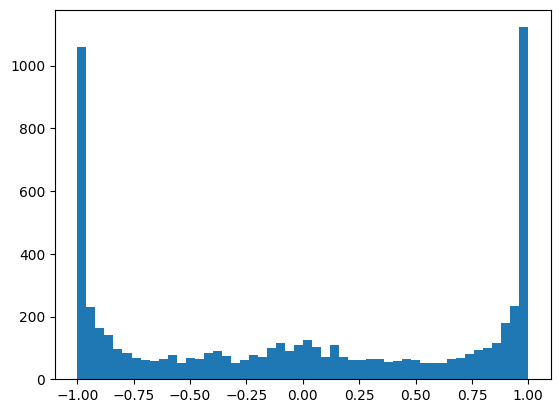

In [80]:
plt.hist(h.view(-1).tolist(), 50);

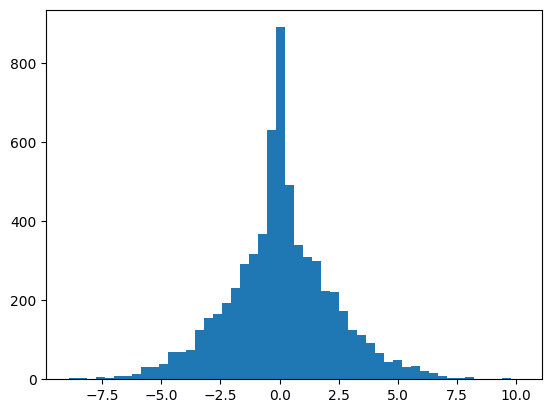

In [81]:
plt.hist(hpreact.view(-1).tolist(), 50);

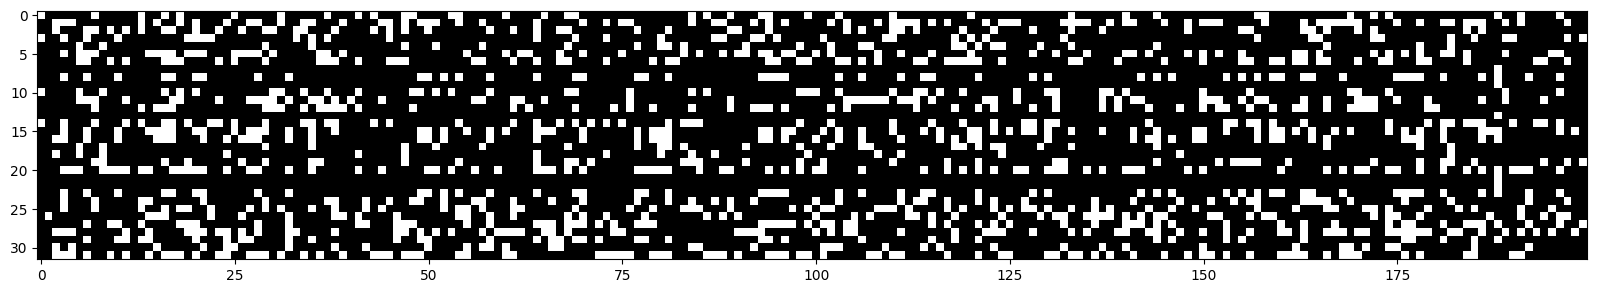

In [82]:
plt.figure(figsize=(20,10))
plt. imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [14]:
# 4-dimensional example of the issue
logits = torch. tensor ([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs [2]. log ()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [24]:
logits = torch. rand (4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs [2]. log ()
logits, probs, loss

(tensor([98.5346, 99.9209, 85.7609, 60.6012]),
 tensor([2.0001e-01, 7.9999e-01, 5.6686e-07, 6.7105e-18]),
 tensor(14.3832))

In [15]:
probs

tensor([0.0066, 0.0066, 0.9802, 0.0066])

In [11]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

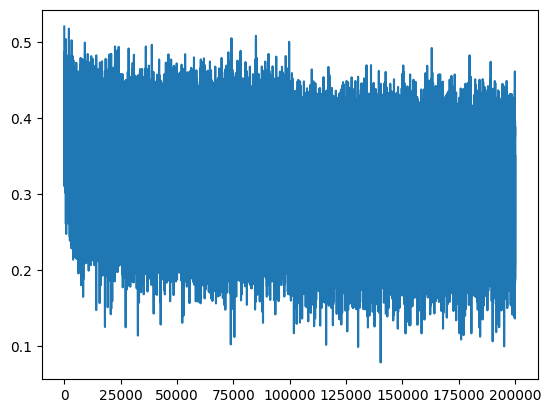

In [83]:
plt.plot(lossi)


In [ ]:
# # calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [92]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss (split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # preact = bngain * (hpreact - bmean) / bnstd + bbias
    preact = bngain * (hpreact - bmean_running) / bnstd_running + bbias

    h = torch. tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab._size)
    loss = F.cross_entropy (logits, y)
    print(split, loss.item( ))
split_loss( 'train')
split_loss( 'val')

train 2.065701723098755
val 2.1107821464538574


In [48]:
# @torch.no_grad() # this decorator disables gradient tracking
# def split_loss(split):
#   x,y = {
#     'train': (Xtr, Ytr),
#     'val': (Xdev, Ydev),
#     'test': (Xte, Yte),
#   }[split]
#   emb = C[x] # (N, block_size, n_embd)
#   embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
#   hpreact = embcat @ W1 # + b1
#   #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
#   hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
#   h = torch.tanh(hpreact) # (N, n_hidden)
#   logits = h @ W2 + b2 # (N, vocab_size)
#   loss = F.cross_entropy(logits, y)
#   print(split, loss.item())

# split_loss('train')
# split_loss('val')

NameError: name 'bngain' is not defined